In [63]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from helper import get_outliers

In [68]:
df = pd.read_csv("datasets/pga.csv")
df = df.loc[df["MW"]>5]
df.head()

,MW,FaultType,Rrup,VS30,PGA
53,6.00,Yanal,78.32,570.00,0.010056
90,7.14,Yanal,168.26,399.61,0.018779
91,6.20,Yanal,67.73,487.34,0.013437
92,6.20,Yanal,63.30,401.26,0.022403
93,6.20,Yanal,75.62,538.69,0.012765


In [69]:
num_cols = ["MW", "Rrup", "VS30", "PGA"]
cat_cols = ["FaultType"]
scaler = StandardScaler()
df_processed = df.copy()
df_processed[num_cols] = scaler.fit_transform(df[num_cols])
df_processed = pd.get_dummies(df_processed, columns=cat_cols, drop_first=True)
X = df_processed.drop("PGA", axis=1)

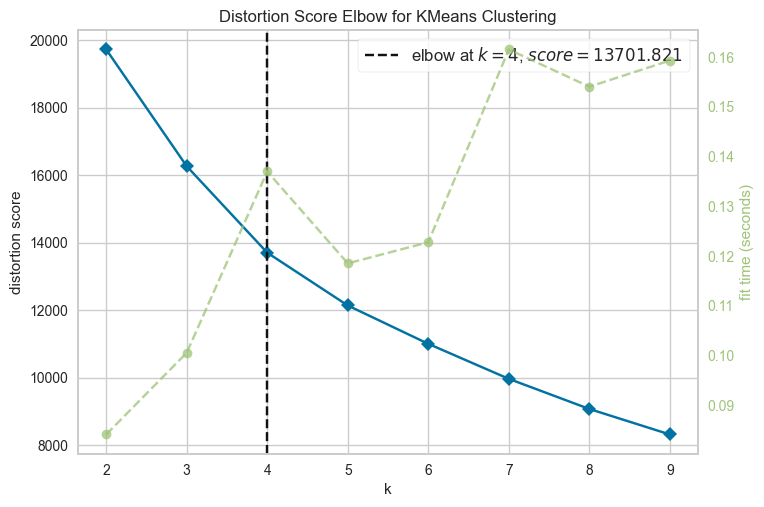

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

In [71]:
from sklearn.model_selection import GridSearchCV

def grid_search(df):
    kmeans_params = {
        "algorithm": ["auto", "full", "elkan"],
    }
    
    kmeans_best_grid = GridSearchCV(
        KMeans(n_clusters=4),
        kmeans_params,
        cv=5,
        n_jobs=-1,
        verbose=True,
    ).fit(df)
    return {"n_clusters":4,**kmeans_best_grid.best_params_}
best_params = grid_search(df_processed)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


c:\Users\burak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [72]:
model = KMeans(**best_params)
clusters = model.fit_predict(df_processed)
df["cluster"] = clusters
df.head()

c:\Users\burak\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


,MW,FaultType,Rrup,VS30,PGA,cluster
53,6.00,Yanal,78.32,570.00,0.010056,1
90,7.14,Yanal,168.26,399.61,0.018779,2
91,6.20,Yanal,67.73,487.34,0.013437,1
92,6.20,Yanal,63.30,401.26,0.022403,1
93,6.20,Yanal,75.62,538.69,0.012765,1


In [76]:
df.to_csv("datasets/pga_clustered_M5.csv", index=False)

In [57]:
df.loc[df["cluster"]==2]["MW"].describe()

count    3706.000000
mean        4.509429
std         0.855947
min         2.990000
25%         3.940000
50%         4.270000
75%         4.770000
max         7.620000
Name: MW, dtype: float64

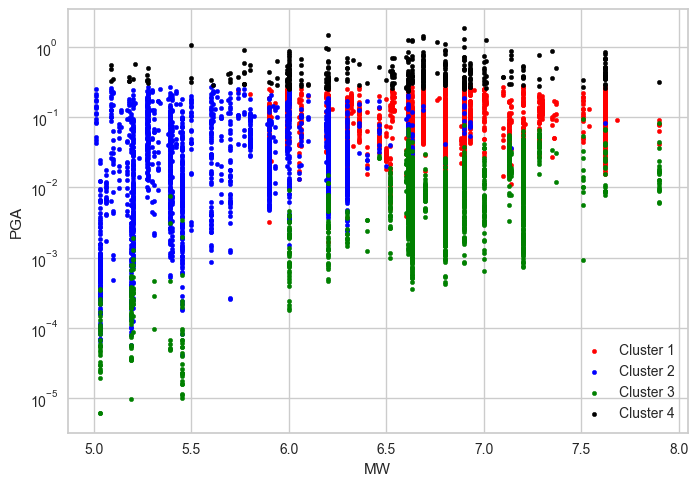

In [73]:
import matplotlib.pyplot as plt
MW = df["MW"]
PGA = df["PGA"]
n_clusters = 4

colors ={0:'red', 1:'blue', 2:'green', 3:'black'}

# create the scatter plot
fig, ax = plt.subplots()
for i in range(n_clusters):
    ax.scatter(MW[clusters == i], PGA[clusters == i], c=colors[i], label=f'Cluster {i+1}',s=10)
ax.legend()
ax.set_xlabel('MW')
ax.set_ylabel('PGA')
plt.semilogy()
plt.legend()
plt.show()

In [74]:
from sklearn.decomposition import PCA

# assuming your data is stored in a Numpy array called "data"
pca = PCA(n_components=2)
data_2d = pca.fit_transform(df_processed.drop("cluster", axis=1))
data_2d = pd.DataFrame(data_2d, columns=["PC1", "PC2"])
data_2d["cluster"] = clusters

KeyError: "['cluster'] not found in axis"

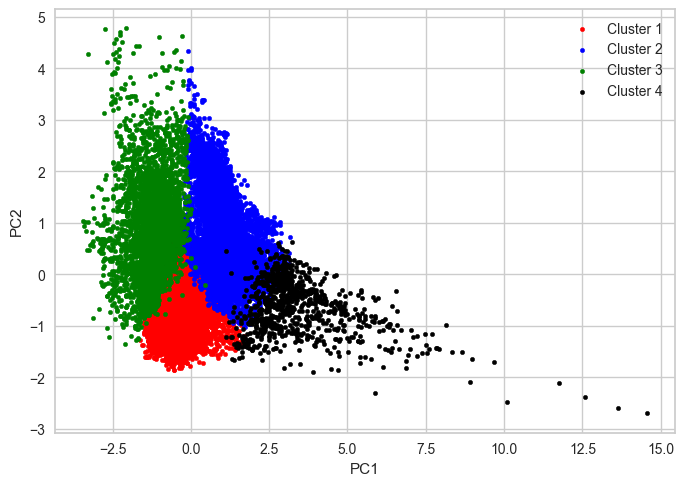

In [43]:
n_clusters = 4
c1 = data_2d["PC1"]
c2 = data_2d["PC2"]
colors ={0:'red', 1:'blue', 2:'green', 3:'black'}

# create the scatter plot
fig, ax = plt.subplots()
for i in range(n_clusters):
    ax.scatter(c1[clusters == i], c2[clusters == i], c=colors[i], label=f'Cluster {i+1}',s=10)
ax.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.semilogy()
plt.legend()
plt.show()

In [45]:
df["cluster"] = clusters
df.to_csv("datasets/pga_Rrup_clustered.csv", index=False)